In [1]:
# ! jupyter labextension list

In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import warnings
from datetime import date, timedelta
import cartopy
import cartopy.crs as ccrs
import cartopy.util
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time

warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
    
    keepVars_noGust = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
                    'U10','CLDHGH','CLDLIQ','TMQ',
                    'PHIS','CDNUMC','CLDLOW',
                    'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
                    'T','Q','OMEGA','PBLH','U','V','Z3',
                    'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC',
                    'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY',
                    'hyam','hybm','hyai','hybi']
    
    keepVars_gust = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
                    'U10', 'UGUST','CLDHGH','CLDLIQ','TMQ',
                    'PHIS','CDNUMC','CLDLOW',
                    'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
                    'T','Q','OMEGA','PBLH','U','V','Z3',
                    'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC',
                    'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY', 
                    'hyam','hybm','hyai','hybi']        
        
    ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    varnames = list(ds.keys())

    if 'UGUST' in varnames: 
        dsSel      = ds[keepVars_gust]
    else: 
        dsSel      = ds[keepVars_noGust]
        # Convert to dask array
        # dsSel['UGUST'] = (('time','lat','lon'), np.full([len(dsSel.time.values), len(dsSel.lat.values), len(dsSel.lon.values)], 0))
    
    return dsSel


def preprocess_h2(ds):
       
    keepVars = ['PRECC','PRECT','U850']
        
    ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    dsSel      = ds[keepVars]

    
    return dsSel



## Read in data

This part has always been at least a little slow, given how many years there are; I'm simplifying to look at just one scenario, but it still takes a long time (a bit more than usual)

In [4]:
# from dask.distributed import Client
# client = Client()  # set up local cluster on your laptop
# client

In [4]:
import dask

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="01:00:00",
    project="P93300642",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

# # scale as needed
# cluster.adapt(minimum_jobs=1, maximum_jobs=30)
# cluster

# # Scale up
# cluster.scale(8)
# cluster


In [5]:
from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.97:45133,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
cluster.scale(24)


In [7]:
client.wait_for_workers(24)

In [2]:
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
9584898.casper* mdfowler jhublog* cr-login-*  22280   1   1    4gb 720:0 R 00:26


In [9]:
%%time
testDir     = '/glade/derecho/scratch/hannay/archive/'

case_IDs  = [
               'BLT1850_054ctrl',
               # 'BLT1850_064gust',    
              ]

caseNames = [
            'b.e23_alpha16b.BLT1850.ne30_t232.054', 
            # 'b.e23_alpha16g.BLT1850.ne30_t232.064',  
        ]    

for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    listFiles_h0 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h0.00??-*'))
    # listFiles_h1 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h2.00??-*'))
    print(len(listFiles_h0))
    
    ## Now read in those files
    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal', parallel='True')
    print('h0 files loaded')
    
    # case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h2, concat_dim='time', 
    #                             combine='nested', decode_times=False, 
    #                             data_vars='minimal', parallel='True')
    # print('h1 files loaded')
    
    ## Add case ID (short name) to the DS
    # case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    # case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    # ## Info on dates available
    # print('Min year (h0): ', np.nanmin(case_h0['time.year'].values))
    # print('Max year (h0): ', np.nanmax(case_h0['time.year'].values))
    # print('Min year (h1): ', np.nanmin(case_h1['time.year'].values))
    # print('Max year (h1): ', np.nanmax(case_h1['time.year'].values))
    
    ## Return all the cases in a single dataset
    # if iCase==0:
    #     all_h0    = case_h0
    #     del case_h0
    #     # all_h1 = case_h1
    #     # del case_h1
    # else: 
    #     all_h0    = xr.concat([all_h0, case_h0], "case") 
    #     del case_h0
    #     # all_h1 = xr.concat([all_h1, case_h1], "case") 
    #     # del case_h1
    

*** Starting on case BLT1850_054ctrl ***
1188
h0 files loaded
CPU times: user 2min 4s, sys: 4.67 s, total: 2min 9s
Wall time: 4min 47s


In [10]:
all_h0 = case_h0


In [8]:
# %%time
# ## Test with removing the preprocess step
# case_h0 = xr.open_mfdataset(listFiles_h0, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal', parallel='True')


CPU times: user 9min 48s, sys: 32.9 s, total: 10min 21s
Wall time: 17min 13s


In [ ]:
# %%time
# ## Test with removing the combine and concat_dim options... maybe those aren't needed? 
# case_h0 = xr.open_mfdataset(listFiles_h0, 
#                                 decode_times=False, 
#                                 data_vars='minimal', parallel='True')


In [ ]:
# %%time
# file_name_h0 = '/glade/derecho/scratch/mdfowler/CoupledRuns_54&64_h0.nc'
# file_name_h1 = '/glade/derecho/scratch/mdfowler/CoupledRuns_54&64_h1.nc'

# all_h0.to_netcdf(file_name_h0, mode='w')
# all_h0.close()

# all_h1.to_netcdf(file_name_h1, mode='w')
# all_h1.close()


Having given up on saving the arrays to netCDF if it takes too long, even computing a Nino 3.4 index and attempting to add that to an array is taking more than an hour as well. 

In [11]:
 %%time
## Make time array usable
from dateutil.relativedelta import relativedelta
def add_months(start_date, num_months):
    return start_date + relativedelta(months=num_months)

def monthly_time_array(start_date, num_months):
    # Convert the start date string to a datetime object
    # start_date = datetime.strptime(start_date, '%Y-%m-%d')

    # Create a list to store the monthly time array
    time_array = []

    # Generate monthly time array
    for i in range(num_months):
        time_array.append(start_date)
        start_date = add_months(start_date, 1)

    return time_array


start_date = datetime.datetime(1850, 1, 1)
num_months = len(all_h0.time.values)
result = monthly_time_array(start_date, num_months)

all_h0['time'] = result

CPU times: user 16.4 ms, sys: 11 µs, total: 16.4 ms
Wall time: 30.6 ms


In [12]:
 %%time
## Compute Nino 3.4 index
ilats = np.where((all_h0.lat.values>=-5)  & (all_h0.lat.values<=5))[0]
ilons = np.where((all_h0.lon.values>=190) & (all_h0.lon.values<=240))[0]

regionTS = all_h0.TS.isel(lat=ilats, lon=ilons).mean(dim='lat').mean(dim='lon')
climoTS  = regionTS.mean(dim='time')
nino34 = (regionTS - climoTS).rolling(time=5).mean()


CPU times: user 120 ms, sys: 112 µs, total: 120 ms
Wall time: 127 ms


This next cell in particular is the one taking *much* longer than it ever did before. 

In [13]:
nino34

<xarray.DataArray 'TS' (time: 1188)>
dask.array<truediv, shape=(1188,), dtype=float32, chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1948-12-01

In [14]:
%%time 
nino34.load()

CPU times: user 9.33 s, sys: 238 ms, total: 9.57 s
Wall time: 12 s


<xarray.DataArray 'TS' (time: 1188)>
array([        nan,         nan,         nan, ...,  0.03925781,
       -0.37841797, -0.6621399 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1948-12-01

In [15]:
#nino34.data.dask

In [16]:
%%time
## Identify winters that are in different ENSO phases?
#    ENSO active when anomaly +/- 0.4 deg for 6+ months

label_case0 = np.full([len(nino34.time.values)], '---------')

for iTime in range(len(nino34.time.values)-10):
    this6months = nino34.isel(time=np.arange(iTime,iTime+6))
    
    if (np.all(this6months.values>=0.4)):
        label_case0[iTime+6] = 'ElNino'
    elif (np.all(this6months.values<=0.4)):
        label_case0[iTime+6] = 'LaNina'
    else:
        label_case0[iTime+6] = 'Neutral'

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 139 ms


In [22]:
%%time
## Identify winters that are in different ENSO phases?
#    ENSO active when anomaly +/- 0.4 deg for 6+ months

label_case0 = np.full([len(nino34.time.values)], '---------')

for iTime in range(len(nino34.time.values)-6):
    this6months = nino34.isel(case=0).isel(time=np.arange(iTime,iTime+6))
    
    if (np.all(this6months.values>=0.4)):
        label_case0[iTime+6] = 'ElNino'
    elif (np.all(this6months.values<=0.4)):
        label_case0[iTime+6] = 'LaNina'
    else:
        label_case0[iTime+6] = 'Neutral'

ValueError: Dimensions {'case'} do not exist. Expected one or more of ('time',)

**For AMWG**

In [40]:
numPoints = 50
numPointsGust = 25

U0 = np.linspace(0,15,numPoints)
Ug = np.linspace(0,3,numPointsGust)

# allsqrt = np.sqrt(U0**2 + Ug**2)
# onesqrt = np.sqrt(U0**2) + Ug 

diff = onesqrt - allsqrt

arr_allsqrt = np.full([numPoints, numPointsGust], np.nan)
arr_onesqrt = np.full([numPoints, numPointsGust], np.nan)

for i0 in range(numPoints): 
    for iG in range(numPointsGust): 
        arr_allsqrt[i0, iG] = np.sqrt((U0[i0]**2)  + (Ug[iG]**2))
        arr_onesqrt[i0, iG] = np.sqrt(U0[i0]**2) + Ug[iG]



Text(0.5, 1.0, 'sqrt(U0^2) + Ug')

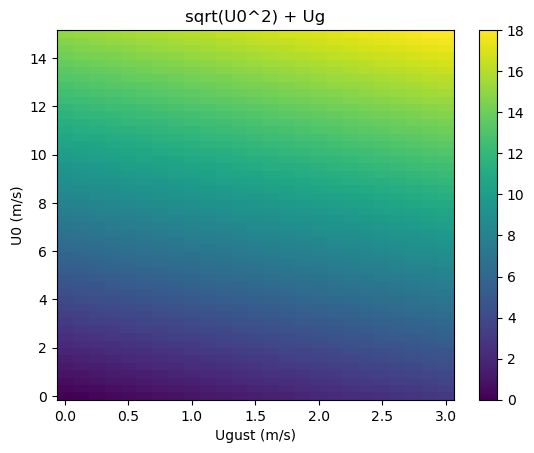

In [45]:
plt.pcolormesh(Ug, U0, arr_onesqrt, vmin=0, vmax=18)
plt.colorbar()
plt.xlabel('Ugust (m/s)')
plt.ylabel('U0 (m/s)')
plt.title('sqrt(U0^2) + Ug')

Text(0.5, 1.0, 'sqrt(U0^2 + Ug^2)')

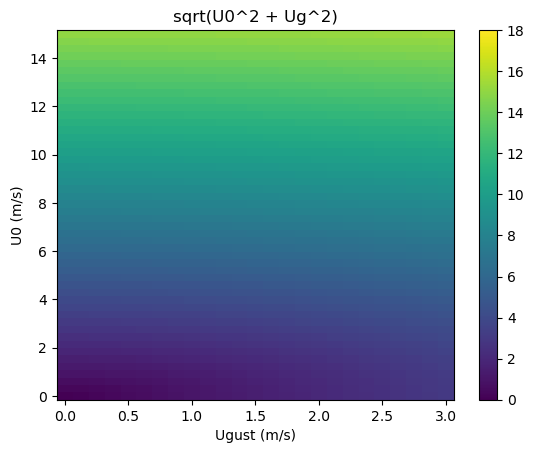

In [46]:
plt.pcolormesh(Ug, U0, arr_allsqrt, vmin=0, vmax=18)
plt.colorbar()
plt.xlabel('Ugust (m/s)')
plt.ylabel('U0 (m/s)')
plt.title('sqrt(U0^2 + Ug^2)')

Text(0.5, 1.0, 'arr_onesqrt-arr_allsqrt')

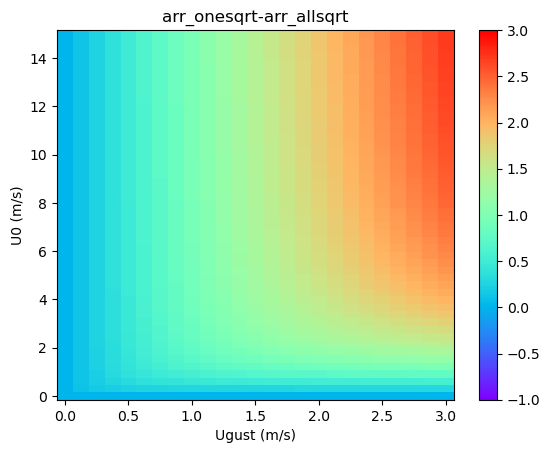

In [52]:
plt.pcolormesh(Ug, U0, arr_onesqrt-arr_allsqrt, cmap='rainbow', vmin=-1,vmax=3)
plt.colorbar()
plt.xlabel('Ugust (m/s)')
plt.ylabel('U0 (m/s)')
plt.title('arr_onesqrt-arr_allsqrt')

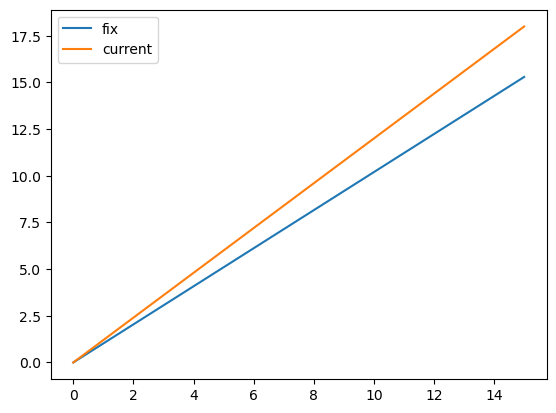

In [19]:
plt.plot(U0, allsqrt, label='fix')
plt.plot(U0, onesqrt, label='current')
plt.legend()

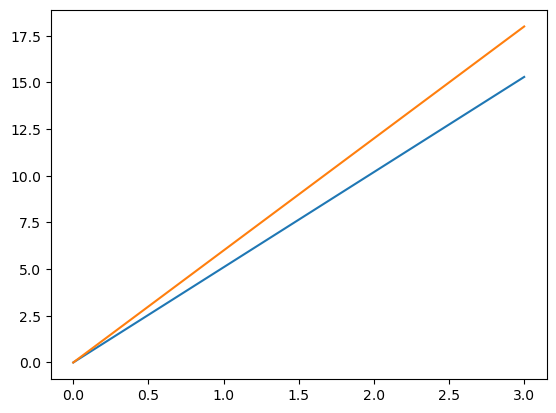

In [13]:
plt.plot(Ug, allsqrt)
plt.plot(Ug, onesqrt)